# Example 1: Monte Carlo vs Effective Quadratures

Some of this notebook is already completed for you. You will need to fill in the ???'s throughout the notebook.

The required python packages are imported here. Ignore this bit!

In [12]:
from equadratures import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

## 1. Defining our example function

Define the function given in the slides.

In [13]:
def our_function(s):
    y = -s**2 + s + 1 
    return y

For a given $s$ ``our_function(s)`` will return $f(s)$, test the function by passing it a number between 0 and 1.

In [14]:
our_function(0.45)

1.2475

As another check, lets plot the function.

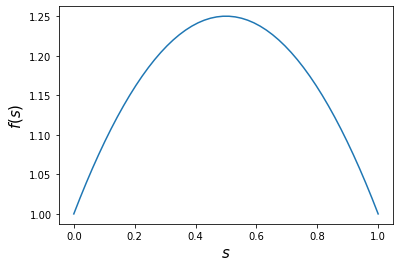

In [15]:
N = 50
s = np.array(np.linspace(0,1,N))
f = our_function(s)
plt.plot(s,f)
plt.xlabel('$s$',fontsize=15)
plt.ylabel('$f(s)$',fontsize=15)
plt.show()

## 2. Computing the moments (mean and variance)

One approach to determining $\bar{y}$ and $Var(y)$ is to randomly $f(s)$ by passing it a random uniform distribution of $s_1$. 

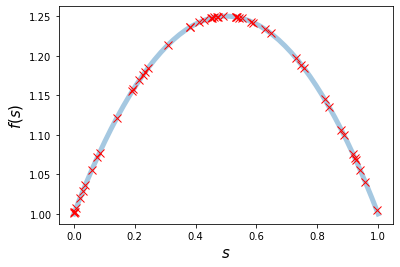

1.1534542229142983 0.007946014517081455


In [16]:
large_number = 50

# np.random.uniform(low=L,high=H,size=N) will generate a numpy ndarray with N samples between L and H
s1_samples = np.random.uniform(low=0,high=1,size=large_number)

# Evaluate f(s) at the points contained in s1_samples
y_samples = our_function(s1_samples)

# Plot our_function and the discreet samples
plt.plot(s,our_function(s),lw=5,alpha=0.4)
plt.plot(s1_samples,y_samples,'xr',ms=8)
plt.xlabel('$s$',fontsize=15)
plt.ylabel('$f(s)$',fontsize=15)
plt.show()

# Print out the mean and variance of our sample distribution y_samples
print(np.mean(y_samples), np.var(y_samples))

Run the above cell a few times, are $\bar{y}$ and $Var(y)$ changing? Do $\bar{y}$ and $Var(y)$ match the theoretical values?

$\bar{y}=1.1\dot{6}$

$Var(y)=0.00\dot{5}$

What $N$ is required for convergence?

## 3. Using Effective Quadratures

Lets now use Effective Quadratures instead. As will become apparent, this involves defining: 
1. **Parameter(s)** 
2. **Basis**
3. **Polynomial**

(see https://www.effective-quadratures.org/_documentation/modules.html)

Start by defining a parameter with a ``uniform`` distribution between 0 and 1.

In [41]:
s1 = Parameter(distribution='uniform', lower=0., upper=1., order=3)
#s1 = Parameter(distribution='Truncated-Gaussian', shape_parameter_A=0.5, shape_parameter_B=0.01,lower=0., upper=1., order=3)

The ``order`` here refers to the order (equivalent to the number of points + 1) of the polynomial along each direction.

### 3a. Exploring the parameter

Lets plot a PDF of the parameter.

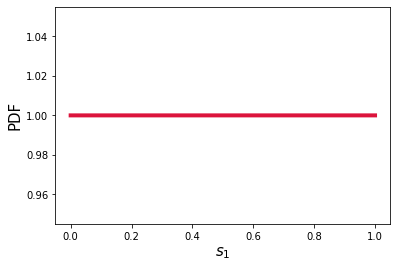

In [42]:
z, pdf = s1.get_pdf()
plt.plot(z, pdf, '-', c='crimson', lw=4)
plt.xlabel('$s_1$', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()

### 3b. Setting the basis

We only have one parameter so lets assume a **univariate basis**.

In [43]:
# Declare a "Basis" object
mybasis = Basis('univariate', orders=[s1.order])

# Print the elements of the Basis with get_elements()
print(mybasis.get_elements())

[[0.]
 [1.]
 [2.]
 [3.]]


### 3c. Defining a polynomial

Now lets define our **polynomial**. The simplest ``method`` for computing the coefficients associated with this polynomial is via ``numerical-integration``. The code will use a tensor product Gaussian quadrature formula to estimate each coefficient of the underlying polynomial expansion. 

In [44]:
# Declare a "Poly" object with parameters=s1, basis=mybasis and method='numerical-integration'
mypoly = Poly(parameters=[s1], basis=mybasis, method='numerical-integration')

### 3d. Design of experiment

To estimate our polynomial's coefficients, one needs to evaluate the model at **design of experiment** (doe) set of points. These points are obtained as follows:

[[0.06943184]
 [0.33000948]
 [0.66999052]
 [0.93056816]]


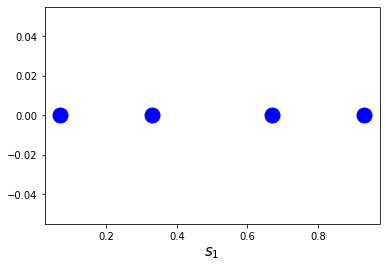

In [45]:
# Get the DOE points from mypoly with get_points()
pts = mypoly.get_points()
print(pts)

# Plot the points
plt.plot(pts, np.zeros_like(pts), 'bo', markersize=15)
plt.xlabel('$s_1$', fontsize=15)
plt.show()

### 3e. Evaluating our hypothetical model at doe points

We need to evaluate ``our_function()`` at the doe ``pts``

In [46]:
f = our_function(pts)  
print(f)

[[1.06461106]
 [1.22110322]
 [1.22110322]
 [1.06461106]]


### 3f. Finding the polynomial coefficients

Lets pass these values back to ``mypoly`` with ``set_model()``, and it will calcuate the coefficients for us!

In [47]:
mypoly.set_model(f)

Home stretch! We now have a polynomial "fit". Lets get it from ``mypoly`` with ``get_polyfit``, and plot it. 

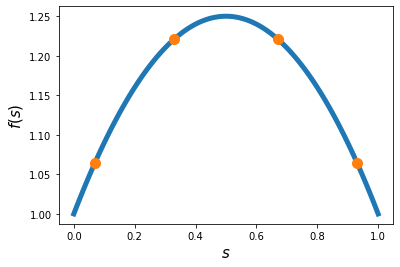

In [48]:
# Get the polyfit function from mypoly
mypolyfit = mypoly.get_polyfit

# Evaluate mypolyfit over 100 points between s1.lower and s2.upper (for plotting only!)
x = np.linspace(s1.lower,s1.upper,100)
y = mypolyfit(x)

plt.plot(x,y,lw=5)
plt.plot(pts,mypolyfit(pts),'o',ms=10)
plt.xlabel('$s$',fontsize=15)
plt.ylabel('$f(s)$',fontsize=15)
plt.show()

### 3g. Computing moments

And the moment of truth...

In [49]:
print(mypoly.get_mean_and_variance())

(1.166666666666667, 0.005555555555555558)


How well does $\bar{y}$ match the theoretical value?

Note that because our ``our_function`` is a polynomial itself, we expect the code to be **exact**!

## 4. Extension: other parameter distributions

Go back to the start of 3) and change the parameter distribution to a ``Truncated-Gaussian``. Start with $\overline{s_1}=0.5$ and $Var(s_1)=0.01$ and truncate the gaussian to the range $0\le s_1\le1$ (you will need the arguments ``shape_parameter_A``, ``shape_parameter_B``, ``lower`` and ``upper``).

Look at what happens to the Effective Quadrature analysis above, and the Monte Carlo sampling below.

1.167592457586817 0.005690380774264554


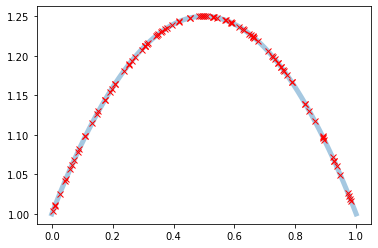

In [56]:
large_number = 100
# Get samples will generate random values within the prescribed distribution.
s1_samples = s1.get_samples(large_number).reshape(large_number, 1)
y_samples = our_function(s1_samples)

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(x,mypolyfit(x),lw=5,alpha=0.4)
ax1.plot(s1_samples,y_samples,'xr')

print(np.mean(y_samples), np.var(y_samples))

Notice how the distribution of sampled $s_1$ points must change if the distribution of $s_1$ changes? Effective Quadratures does this for us behind the scenes!

As an interesting aside, below is the resulting PDF of $y=f(s_1)$.

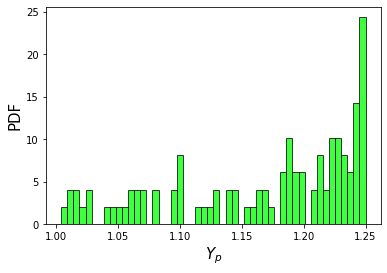

In [57]:
# PDF of s2 is plotted here
n, bins, patches = plt.hist(y_samples, 50, density=True, facecolor='lime', alpha=0.75, edgecolor='k')
plt.xlabel(r'$Y_p$', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.show()